In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math
import numpy as np
import random
import pickle
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import os
path=os.path.join(os.getcwd(),'My Drive/shuffled_images/data_train/64-sources')
pre_path=os.path.join(os.getcwd(),'My Drive/shuffled_images/data_train')
images=os.listdir(path)

In [0]:
def preprocess(start,end):
  dataX=[]
  dataY=[]
  for image in tqdm(images[start:end]):
    im = imread(os.path.join(path,image))
    h=im.shape[0]
    if len(im.shape)==2:
      continue
    #print(image)
    nfrags=h//fsize

    for i in range(nfrags):
      for j in range(nfrags):

        if (i+1)<nfrags:
          dataX.append( np.rot90(im[i*fsize:(i+2)*fsize,j*fsize:(j+1)*fsize,:],1,(1,0)))
          dataY.append(1)

        if (j+1)<nfrags:
          dataX.append( im[i*fsize:(i+1)*fsize,j*fsize:(j+2)*fsize,:] )
          dataY.append(1)

        random_row=[ random.choice(range(0,i-2)) if i>2 else nfrags-1,random.choice(range(i+2,nfrags)) if i<nfrags-2 else 0 ]
        random_column=[ random.choice(range(0,j-2)) if j>2 else nfrags-1,random.choice(range(j+2,nfrags)) if j<nfrags-2 else 0 ]  

        for r in random_row:
          for c in random_column:
            rand_img=im[r*fsize:(r+1)*fsize,c*fsize:(c+1)*fsize,:]
            img=im[i*fsize:(i+1)*fsize,j*fsize:(j+1)*fsize,:]
            dataX.append(np.concatenate((img,rand_img),1))
            dataY.append(0)
     
  np.save(pre_path+'/datax.npy', dataX) # save
  np.save(pre_path+'/datay.npy', dataY) # save
  return np.array(dataX),np.array(dataY)




NameError: ignored

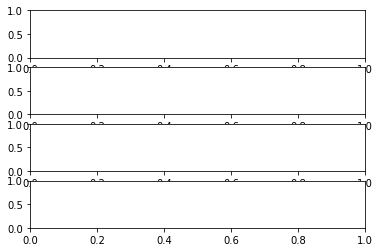

In [0]:
fig,pt=plt.subplots(4)
for index in range(4):
  pt[index].imshow(dataX[index])
  print(dataY[index])

In [0]:
fsize=16
start=0
end=120
if(input("press ----t--- to train :")=='t'):
  dataX,dataY=preprocess(start,end)
else:
  try:
    dataX =  np.load(pre_path+'/datax.npy') # load
    dataY =  np.load(pre_path+'/datay.npy') # load
  except:
    print("preprocessed data not found...processing...")
    dataX,dataY=preprocess(start,end)
  

press ----t--- to train :n


In [0]:
data_X=dataX/255
data_Y=dataY
train_X,valid_X,train_Y,valid_Y = train_test_split(data_X, data_Y, test_size=0.2, random_state=13)

In [0]:
def get_model():
  num_classes=1
  
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(fsize,fsize*2,3),padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(16, kernel_size=(5, 3),activation='linear',padding='valid'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation='linear'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(32, activation='linear'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(num_classes, activation='sigmoid'))
  model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
  return model

In [0]:
dataX.shape
model=get_model()
model.summary()
batch_size=40
epochs=10


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 16, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 30, 16)        7696      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 12, 30, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 15, 16)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)              

In [0]:
model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_Y))

Train on 218880 samples, validate on 54720 samples
Epoch 1/10
218880/218880 [==============================] - 212s 970us/step - loss: 0.1040 - acc: 0.9599 - val_loss: 0.1033 - val_acc: 0.9601
Epoch 2/10
218880/218880 [==============================] - 213s 974us/step - loss: 0.0994 - acc: 0.9619 - val_loss: 0.1075 - val_acc: 0.9587
Epoch 3/10
218880/218880 [==============================] - 212s 967us/step - loss: 0.0959 - acc: 0.9629 - val_loss: 0.1100 - val_acc: 0.9588
Epoch 4/10
218880/218880 [==============================] - 213s 974us/step - loss: 0.0938 - acc: 0.9639 - val_loss: 0.1003 - val_acc: 0.9616
Epoch 5/10
218880/218880 [==============================] - 213s 974us/step - loss: 0.0911 - acc: 0.9645 - val_loss: 0.0998 - val_acc: 0.9625
Epoch 6/10
218880/218880 [==============================] - 213s 975us/step - loss: 0.0883 - acc: 0.9656 - val_loss: 0.1066 - val_acc: 0.9615
Epoch 7/10
218880/218880 [==============================] - 214s 979us/step - loss: 0.0849 - acc:

In [0]:
pickle.dump(model,open('./My Drive/shuffled_images/models/second_957.pkl','wb'))

In [0]:
model.predict(valid_X[0:10])

NameError: ignored

In [0]:
valid_Y[0:10]

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0])

In [0]:
test_X,y_true=preprocess(105,150)
text_X=test_X/255
y_pred=model.predict(test_X)
y_pred=y_pred.astype('int64')
accuracy_score(y_true,y_pred)

100%|██████████| 45/45 [00:16<00:00,  1.98it/s]


[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


0.9024707602339181

In [0]:
import heapq
for image in test_images:
  h=image.shape[0];
  f_size=16
  n_frags=h/f_size
  frags=[]
  r_frags=[]
  for i in range(nfrags):
      for j in range(nfrags):
          frags.append(im[i*fsize:(i+1)*fsize,j*fsize:(j+1)*fsize,:])
          r_frags.append(np.rot90(im[i*fsize:(i+1)*fsize,j*fsize:(j+1)*fsize,:],1,(1,0)))
  t_frags=len(frags)
  first=random.choice(range(0,t_frags))
  is_taken=[0] * t_frags
  allocated={}
  allocated[(0,0)]=first
  heapq.heapify([(0,(0,0,first))])
  rmax=0
  rmin=0
  cmax=0
  cmin=0
  #heapq.heappush(heap,first)
  while len(allocated)<t_frags:
    best=heapq.heappop(heap)
    r=best[1][0]
    c=best[1][1]
    f=best[1][2]
    if((r>rmax and r-rmin>n_frag) or (r<rmin and rmax-r>n_frag)):
      continue
    if((c>cmax and c-cmin>n_frag) or (c<cmin and cmax-c>n_frag)):
      continue
    rmax=max(r,rmax)
    rmin=min(r,rmin)
    cmax=max(c,cmax)
    cmin=min(c,cmin)
    
    allocated[(r,c)]=f
    if not allocated.has_key((r+1,c)):
      for frag,ind in enumerate(frags):
        if is_taken(ind)==1:
          
      
    
    
    
  
  